In [1]:
import requests
import json
from tqdm import tqdm_notebook
import time
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
import seaborn as sns
import catboost
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import warnings
warnings.filterwarnings('ignore')

Цель: предсказать стоимость билетов в октябре 2020 при нахождении в городе назначения от 1 до 2 недель из любого города России в любой город мира, для использование результата в модели по предсказанию дохода человека(клиента).

In [2]:
# города 

temp_url = 'http://api.travelpayouts.com/data/ru/cities.json'

temp_ids = json.loads(requests.get(temp_url).content.decode())
city = pd.DataFrame(temp_ids)

ru_city = city.code[city.country_code=='RU'].value_counts().index        #Российские города
no_ru_city = city.code[city.country_code!='RU'].value_counts().index     #Иностранные города

print(city.shape)
city.head(1)

(9420, 7)


,time_zone,name,coordinates,code,cases,name_translations,country_code
0,Asia/Shanghai,Линьфэнь,"{'lon': 111.64158, 'lat': 36.13222}",LFQ,"{'vi': '', 'tv': '', 'ro': '', 'pr': '', 'da':...",{'en': 'Linfen'},CN


In [3]:
# страны

temp_url = 'http://api.travelpayouts.com/data/ru/countries.json'
temp_ids = json.loads(requests.get(temp_url).content.decode())
data_country_code = pd.DataFrame(temp_ids)

country_code = data_country_code.code.value_counts().index
country_code = country_code.drop('RU') #Код всех стран кроме России

print(data_country_code.shape)
data_country_code.head(1)

(251, 5)


,name,currency,code,cases,name_translations
0,Испания,EUR,ES,"{'vi': 'в Испанию', 'tv': 'Испанией', 'ro': 'И...",{'en': 'Spain'}


In [4]:
class ApiAviaSales:
    
    
    def __init__(self, access_token='73e3e6de3c2d443c19d984cea762bc82', api_route = 'http://api.travelpayouts.com/'):
        
        self.access_token = access_token
        self.api_route = api_route
          
    
    def get_price(self, destination, currency='rub', sorting='price', page='1', trip_duration='1', origin='RU',
                  beginning_of_period='2020-10-01', period_type='month', one_way='true', limit='999',
                  method='v2/prices/latest'):
    
        
        data = []
        
        
        temp_url = f'{self.api_route}{method}?currency={currency}&page={page}&trip_duration={trip_duration}\
                     &origin={origin}&sorting={sorting}&destination={destination}&beginning_of_period={beginning_of_period}\
                     &period_type={period_type}&one_way={one_way}&limit={limit}&token={self.access_token}'
        
        
        temp_ids = json.loads(requests.get(temp_url).content.decode())    
            
        data.extend(temp_ids['data'])
            
         
        return data # возвращаем список

In [5]:
#Проверим, как работать с полученными данными

api = ApiAviaSales()
Train_data = pd.DataFrame(api.get_price(destination='ES', one_way='false', beginning_of_period='2020-10-01'))

print(Train_data.shape)
Train_data.head(1)

(108, 13)


,value,trip_class,show_to_affiliates,return_date,origin,number_of_changes,gate,found_at,duration,distance,destination,depart_date,actual
0,5778,0,True,2020-10-14,MOW,1,Kiwi.com,2020-08-16T14:55:03.403703,2175,3319,VLC,2020-10-05,True


In [6]:
((Train_data.origin+Train_data.destination).value_counts()>1).sum()   #рейсы не повторяются(это все возможные направления)

0

In [7]:
api = ApiAviaSales()
Train_data2 = pd.DataFrame(api.get_price(destination='RU', origin = 'ES', one_way='true'))

print(Train_data.shape)
Train_data2.head(1)

(108, 13)


,value,trip_class,show_to_affiliates,return_date,origin,number_of_changes,gate,found_at,duration,distance,destination,depart_date,actual
0,2705,0,True,None,BCN,1,Kiwi.com,2020-08-16T07:27:36.940202,800,2823,LED,2020-10-07,True


In [8]:
#Обьединим два датафрейма в один по направлениям

Train_data['origin_destination'] = Train_data.origin + Train_data.destination
Train_data2['origin_destination'] = Train_data2.destination + Train_data2.origin

Train_data_merge = Train_data.merge(Train_data2, left_on='origin_destination', right_on='origin_destination')
print(Train_data_merge.shape)
Train_data_merge.head(1)

(37, 27)


,value_x,trip_class_x,show_to_affiliates_x,return_date_x,origin_x,number_of_changes_x,gate_x,found_at_x,duration_x,distance_x,destination_x,depart_date_x,actual_x,origin_destination,value_y,trip_class_y,show_to_affiliates_y,return_date_y,origin_y,number_of_changes_y,gate_y,found_at_y,duration_y,distance_y,destination_y,depart_date_y,actual_y
0,5778,0,True,2020-10-14,MOW,1,Kiwi.com,2020-08-16T14:55:03.403703,2175,3319,VLC,2020-10-05,True,MOWVLC,3392,0,True,None,VLC,1,Kiwi.com,2020-08-15T01:32:30.260743,835,3319,MOW,2020-10-07,True


In [9]:
# Теперь создадим список со всеми направлениями из России в зарубежные страны

data = []


for des in tqdm_notebook(country_code):
    api = ApiAviaSales()
    data.extend(api.get_price(destination=des, one_way='true'))

Data_for_parsing = pd.DataFrame(data)

In [10]:
print(Data_for_parsing.shape)
Data_for_parsing.head(1)

(3019, 13)


,value,trip_class,show_to_affiliates,return_date,origin,number_of_changes,gate,found_at,duration,distance,destination,depart_date,actual
0,39556,0,True,None,MOW,2,OneTwoTrip,2020-08-16T16:47:50.610216,1340,8351,TNR,2020-10-23,True


In [11]:
trip_from_russia = []
for orig, dest in zip(Data_for_parsing.origin, Data_for_parsing.destination):
    trip_from_russia.append([orig, dest])
    

In [ ]:
#Скачаем данные из России в другие страны в одну сторону в октябре(10.2020)

data = []

for code in tqdm_notebook(trip_from_russia):
    api = ApiAviaSales()
    data.extend(api.get_price(origin=code[0], destination=code[1], one_way='true'))
    
Data_from_russia = pd.DataFrame(data)

In [ ]:
data = []


for code in tqdm_notebook(trip_from_russia):
    api = ApiAviaSales()
    data.extend(api.get_price(origin=code[1], destination=code[0], one_way='true'))
    
Data_to_russia = pd.DataFrame(data)

In [ ]:
#Data_from_russia.to_csv('./data/Data_from_russia', index=False)
#Data_to_russia.to_csv('./data/Data_to_russia', index=False)

In [ ]:
Data_from_russia = pd.read_csv('./data/Data_from_russia')
Data_to_russia = pd.read_csv('./data/Data_to_russia')

In [ ]:
Data_from_russia['origin_destination'] = Data_from_russia.origin + Data_from_russia.destination
Data_to_russia['origin_destination'] = Data_to_russia.destination + Data_to_russia.origin

In [ ]:
Data_from_russia['depart_date'] = pd.to_datetime(Data_from_russia['depart_date'])
Data_to_russia['depart_date'] = pd.to_datetime(Data_to_russia['depart_date'])

In [ ]:
Data_to_analys=Data_from_russia.iloc[[0]].merge(Data_to_russia.iloc[[0]], on='origin_destination')

for str_dfr in tqdm_notebook(range(Data_from_russia.shape[0])): 
    dfr = Data_from_russia.origin_destination.iloc[str_dfr]
    
    for str_dtr in range(Data_to_russia.shape[0]): 
        dtr = Data_to_russia.origin_destination.iloc[str_dtr]
        
        if dfr == dtr and 7 <= (Data_to_russia['depart_date'].iloc[str_dtr].day - \
        Data_from_russia['depart_date'].iloc[str_dfr].day) < 15:
            data_to_concate=Data_from_russia.iloc[[str_dfr]].merge(Data_to_russia.iloc[[str_dtr]], on='origin_destination')
            Data_to_analys=pd.concat([Data_to_analys, data_to_concate])
            
Data_to_analys.reset_index(inplace=True)
Data_to_analys.drop(columns='index', axis=1, inplace=True)
Data_to_analys.drop([0], axis=0, inplace=True)

Data_to_analys.to_csv('./data/Data_to_analys')

In [12]:
Data_to_analys = pd.read_csv('./data/Data_to_analys')

In [13]:
print(Data_to_analys.shape)
Data_to_analys.head(1)

(3010, 30)


,Unnamed: 0,Unnamed: 0_x,value_x,trip_class_x,show_to_affiliates_x,return_date_x,origin_x,number_of_changes_x,gate_x,found_at_x,duration_x,distance_x,destination_x,depart_date_x,actual_x,origin_destination,Unnamed: 0_y,value_y,trip_class_y,show_to_affiliates_y,return_date_y,origin_y,number_of_changes_y,gate_y,found_at_y,duration_y,distance_y,destination_y,depart_date_y,actual_y
0,1,0,2916,0,True,NaN,MOW,0,KupiBilet.ru,2020-07-12T09:56:26.394343,100,849,RIX,2020-10-14,True,MOWRIX,0,2916,0,True,NaN,RIX,0,KupiBilet.ru,2020-07-12T22:02:03.614686,95,849,MOW,2020-10-26,True


In [14]:
Data_to_analys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3010 entries, 0 to 3009
Data columns (total 30 columns):
Unnamed: 0              3010 non-null int64
Unnamed: 0_x            3010 non-null int64
value_x                 3010 non-null int64
trip_class_x            3010 non-null int64
show_to_affiliates_x    3010 non-null bool
return_date_x           0 non-null float64
origin_x                3010 non-null object
number_of_changes_x     3010 non-null int64
gate_x                  3010 non-null object
found_at_x              3010 non-null object
duration_x              3010 non-null int64
distance_x              3010 non-null int64
destination_x           3010 non-null object
depart_date_x           3010 non-null object
actual_x                3010 non-null bool
origin_destination      3010 non-null object
Unnamed: 0_y            3010 non-null int64
value_y                 3010 non-null int64
trip_class_y            3010 non-null int64
show_to_affiliates_y    3010 non-null bool
return_date

In [15]:
# В данных две фичи имеют нулы, так и должно быть, так как return_day_y это дата возвращения(depart_day_y)

In [16]:
#подготовим данные для бейслайна

Data_to_baseline = Data_to_analys.copy()

Data_to_baseline['total_value'] = Data_to_baseline.value_x + Data_to_baseline.value_y
Data_to_baseline = Data_to_baseline.drop(['origin_y', 'destination_y', 'value_x', 'value_y', 'trip_class_x',
                                          'trip_class_y', 'show_to_affiliates_x', 'show_to_affiliates_y', 
                                          'return_date_x', 'return_date_y', 'gate_x', 'gate_y', 'duration_x',
                                          'distance_x', 'origin_destination', 'actual_x', 'actual_y',
                                          'Unnamed: 0_x', 'Unnamed: 0_y'],axis=1)

Data_to_baseline.rename(columns={'number_of_changes_x':'number_of_changes_from_Russia',
                                 'number_of_changes_y':'number_of_changes_to_Russia',
                                 'origin_x':'origin', 'destination_x':'destination', 'depart_date_x':'depart_date',
                                 'depart_date_y':'return_date', 'duration_y':'duration', 'distance_y':'distance'},
                                 inplace=True)

Data_to_baseline = Data_to_baseline[['origin', 'destination', 'number_of_changes_from_Russia',
                                   'number_of_changes_to_Russia', 'duration', 'distance', 'total_value']]

In [17]:
Data_to_baseline.head(1)

,origin,destination,number_of_changes_from_Russia,number_of_changes_to_Russia,duration,distance,total_value
0,MOW,RIX,0,0,95,849,5832


In [18]:
# построим первый бейслайн

Data_to_baseline_Y = Data_to_baseline['total_value']
Data_to_baseline_X = Data_to_baseline.drop(['total_value'], axis=1)

Data_to_baseline_X = pd.get_dummies(Data_to_baseline_X, columns=['origin', 'destination', 'number_of_changes_to_Russia',
                                                                 'number_of_changes_from_Russia'])

In [19]:
skf = StratifiedKFold(5, shuffle=True, random_state=54)

scores_RMSE = []
scores_R2 = []

for train_index, test_index in skf.split(Data_to_baseline_X, Data_to_baseline_Y):
   
    X_train, X_test= Data_to_baseline_X.iloc[train_index], Data_to_baseline_X.iloc[test_index]
    Y_train, Y_test= Data_to_baseline_Y.iloc[train_index], Data_to_baseline_Y.iloc[test_index]
    
    model = xgb.XGBRegressor(objective ='reg:squarederror',
                             learning_rate=0.1,
                             n_estimators=300,
                             max_depth=3,
                             min_child_weight=1,
                             gamma=0.1, 
                             colsample_bytree=0.9,
                             subsample=0.9,   
                             n_jobs=-1)
    
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)

    scores_R2.append(r2(Y_test, preds))
    scores_RMSE.append(np.sqrt(mse(Y_test, preds)))
    
    
print(f'RMSE is {round(np.mean(scores_RMSE), 4)}')   
print(f'R2 is {round(np.mean(scores_R2), 4)}')

RMSE is 3100.2897
R2 is 0.9245


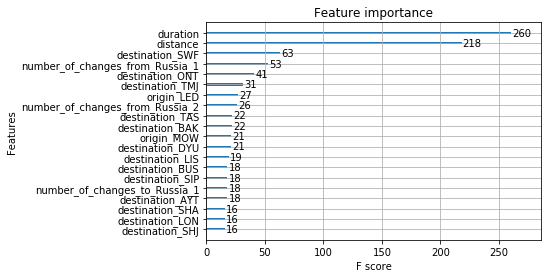

In [20]:
xgb.plot_importance(model, max_num_features = 20)
plt.show()

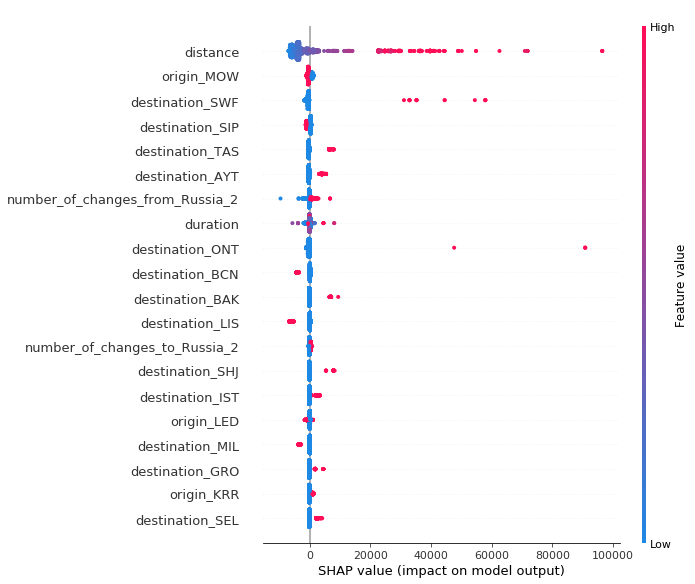

In [21]:
import shap

model = xgb.XGBRegressor(objective ='reg:squarederror',
                         learning_rate=0.1,
                         n_estimators=300,
                         max_depth=3,
                         min_child_weight=1,
                         gamma=0.1, 
                         colsample_bytree=0.9,
                         subsample=0.9,   
                         n_jobs=-1)
    

model.fit(Data_to_baseline_X, Data_to_baseline_Y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Data_to_baseline_X)

shap.summary_plot(shap_values,Data_to_baseline_X)

In [26]:
#построим бейслайн для катубста

categorical_features = Data_to_baseline_X.dtypes[Data_to_baseline_X.dtypes=='object'].index

cat_features = categorical_features
skf = StratifiedKFold(5, shuffle=True, random_state=55)

scores_RMSE = []
scores_R2 = []

for train_index, test_index in skf.split(Data_to_baseline_X, Data_to_baseline_Y):
   
    
    X_train, X_test = Data_to_baseline_X.iloc[train_index], Data_to_baseline_X.iloc[test_index]
    y_train, y_test = Data_to_baseline_Y.iloc[train_index], Data_to_baseline_Y.iloc[test_index]
    
    model = catboost.CatBoostRegressor(depth=7, learning_rate=0.1, iterations=300)

    model.fit(X_train, y_train,cat_features=cat_features,logging_level='Silent')
    
    
    preds = model.predict(X_test)
    scores_R2.append(r2(y_test, preds))
    scores_RMSE.append(np.sqrt(mse(y_test, preds)))
    
print(f'RMSE is {round(np.mean(scores_RMSE), 4)}')   
print(f'R2 is {round(np.mean(scores_R2), 4)}')

RMSE is 2703.1414
R2 is 0.9421


In [27]:
# исходя из важности признаков можно увидеть, что больше всего цена зависит от дистнции \ 
# и длительности полета, проверим на сколько эти два признака коррелируют между собой, 
# влияет и колличество пересадок, посмотрим на графики пересадок в пункте EDA
# большой вклад в модель вносит город вылета, назначения(из Москвы летать дешевле, так как там происхдят пересадки из 
# другиз городов России)

# EDA

In [28]:
print(Data_to_analys.shape)
Data_to_analys.head(1)

(3010, 30)


,Unnamed: 0,Unnamed: 0_x,value_x,trip_class_x,show_to_affiliates_x,return_date_x,origin_x,number_of_changes_x,gate_x,found_at_x,duration_x,distance_x,destination_x,depart_date_x,actual_x,origin_destination,Unnamed: 0_y,value_y,trip_class_y,show_to_affiliates_y,return_date_y,origin_y,number_of_changes_y,gate_y,found_at_y,duration_y,distance_y,destination_y,depart_date_y,actual_y
0,1,0,2916,0,True,NaN,MOW,0,KupiBilet.ru,2020-07-12T09:56:26.394343,100,849,RIX,2020-10-14,True,MOWRIX,0,2916,0,True,NaN,RIX,0,KupiBilet.ru,2020-07-12T22:02:03.614686,95,849,MOW,2020-10-26,True


In [29]:
Data_to_analys['total_value'] = Data_to_analys.value_x + Data_to_analys.value_y

Data_to_analys.drop(columns=['origin_y', 'destination_y', 'value_x', 'value_y', 'trip_class_x',
                             'trip_class_y', 'show_to_affiliates_x', 'show_to_affiliates_y', 
                             'return_date_x', 'return_date_y', 'gate_x', 'gate_y', 'duration_x',
                             'distance_x', 'origin_destination', 'actual_x', 'actual_y',
                             'Unnamed: 0_x', 'Unnamed: 0_y'],inplace=True)


Data_to_analys.rename(columns={'number_of_changes_x':'number_of_changes_from_Russia', 'found_at_x':'found_at_from_Russia',
                               'number_of_changes_y':'number_of_changes_to_Russia', 'found_at_y':'found_at_to_Russia',
                               'origin_x':'origin', 'destination_x':'destination', 'depart_date_x':'depart_date',
                               'depart_date_y':'return_date', 'duration_y':'duration', 'distance_y':'distance'},
                                inplace=True)


Data_to_analys = Data_to_analys[['origin', 'destination', 'number_of_changes_from_Russia', 'number_of_changes_to_Russia',
                                 'depart_date','return_date','found_at_from_Russia', 'found_at_to_Russia', 'duration',
                                 'distance', 'total_value']]

In [30]:
Data_to_analys.head(1)

,origin,destination,number_of_changes_from_Russia,number_of_changes_to_Russia,depart_date,return_date,found_at_from_Russia,found_at_to_Russia,duration,distance,total_value
0,MOW,RIX,0,0,2020-10-14,2020-10-26,2020-07-12T09:56:26.394343,2020-07-12T22:02:03.614686,95,849,5832


In [31]:
Data_to_analys.describe()

,number_of_changes_from_Russia,number_of_changes_to_Russia,duration,distance,total_value
count,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000
mean,0.869103,0.996678,1140.221595,2735.100332,16499.973754
std,0.732937,0.760867,865.710201,1934.612822,15221.491204
min,0.000000,0.000000,60.000000,1.000000,1549.000000
25%,0.000000,0.000000,265.000000,1678.000000,8273.000000
50%,1.000000,1.000000,970.000000,2202.000000,11871.000000
75%,1.000000,2.000000,1760.000000,2997.000000,18568.750000
max,2.000000,2.000000,3707.000000,14512.000000,234920.000000


In [32]:
Data_to_analys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3010 entries, 0 to 3009
Data columns (total 11 columns):
origin                           3010 non-null object
destination                      3010 non-null object
number_of_changes_from_Russia    3010 non-null int64
number_of_changes_to_Russia      3010 non-null int64
depart_date                      3010 non-null object
return_date                      3010 non-null object
found_at_from_Russia             3010 non-null object
found_at_to_Russia               3010 non-null object
duration                         3010 non-null int64
distance                         3010 non-null int64
total_value                      3010 non-null int64
dtypes: int64(5), object(6)
memory usage: 258.8+ KB


In [33]:
Data_to_analys['found_at_to_Russia'] = pd.to_datetime(Data_to_analys['found_at_to_Russia'])
Data_to_analys['found_at_from_Russia'] = pd.to_datetime(Data_to_analys['found_at_to_Russia'])
Data_to_analys['depart_date'] = pd.to_datetime(Data_to_analys['depart_date'])
Data_to_analys['return_date'] = pd.to_datetime(Data_to_analys['return_date'])

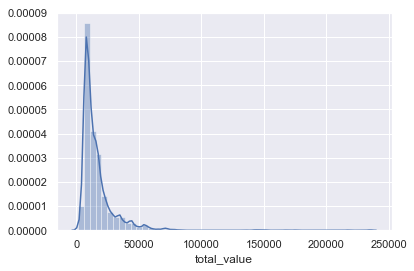

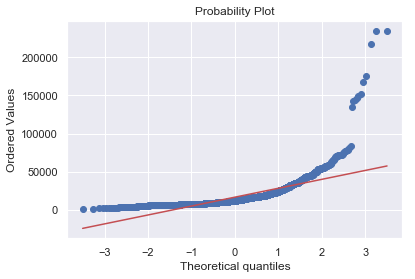

In [34]:
sns.distplot(Data_to_analys.total_value);

fig = plt.figure()
res = sc.stats.probplot(Data_to_analys.total_value, plot=plt)
plt.show()

In [35]:
#избавимся от анамально высоких значений

Data_to_analys[Data_to_analys.total_value>sc.quantile(Data_to_baseline.total_value, 0.99)].shape

(31, 11)

In [36]:
Data_to_analys = Data_to_analys[Data_to_analys.total_value<sc.quantile(Data_to_baseline.total_value, 0.99)]

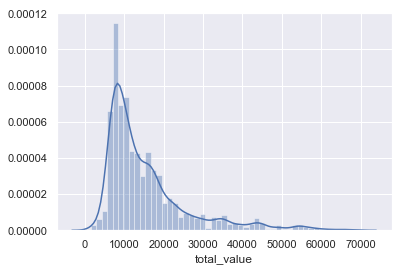

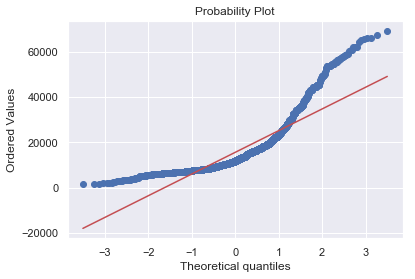

In [37]:
sns.distplot(Data_to_analys.total_value);

fig = plt.figure()
res = sc.stats.probplot(Data_to_analys.total_value, plot=plt)
plt.show()

# Колличественные признаки

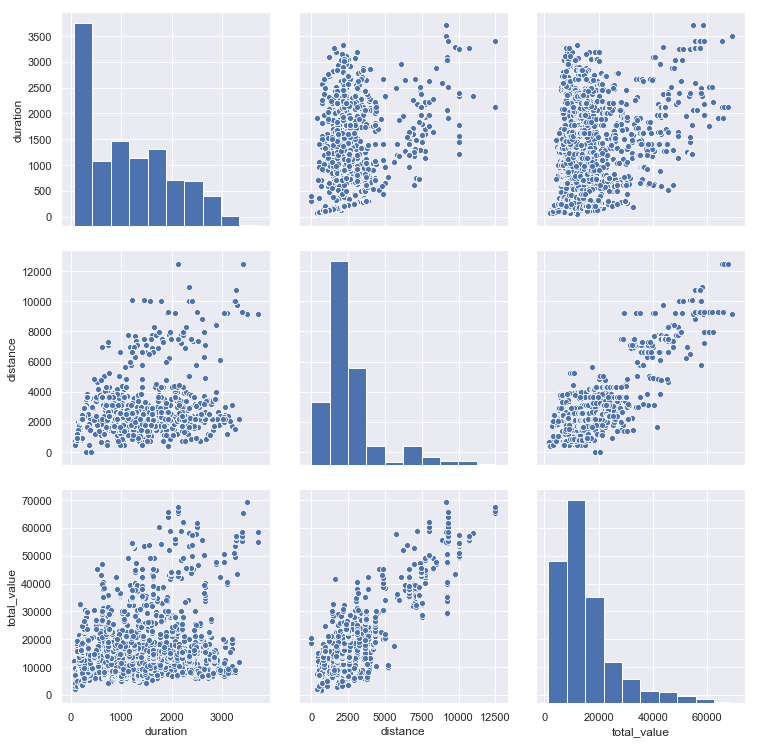

In [38]:
# посмотрим на влияние признаков на целевую переменную и друг на друга

sns.set()
cols = ['duration', 'distance', 'total_value']
sns.pairplot(Data_to_analys[cols], size = 3.5)
plt.show();

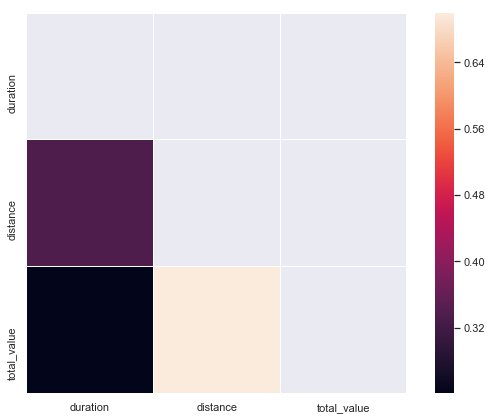

In [39]:
# посмотрим на корреляцию признаков с целевой переменной и между собой

corrmat = Data_to_analys[cols].corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(10,7))
sns.heatmap(corrmat, mask=mask, linewidths=.5, vmax=0.7, square=True);

# Категориальные признаки

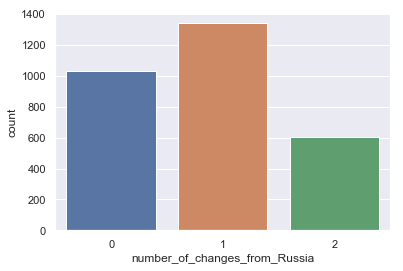

In [40]:
# посмотрим на распределение пересадок из России

sns.countplot(Data_to_analys.number_of_changes_from_Russia);

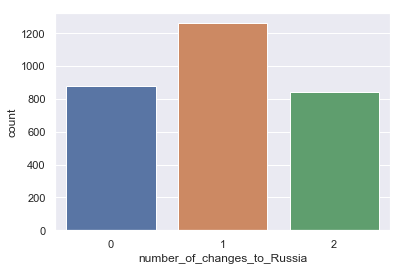

In [41]:
# посмотрим на распределение пересадок в Россию

sns.countplot(Data_to_analys.number_of_changes_to_Russia);

In [42]:
# Создадим новый признак, колличество пересадок из России и в Россию

Data_to_analys.number_of_changes_from_Russia = Data_to_analys.number_of_changes_from_Russia.astype('str')
Data_to_analys.number_of_changes_to_Russia = Data_to_analys.number_of_changes_to_Russia.astype('str')

Data_to_analys['number_of_changes_from/to_Russia'] = Data_to_analys.number_of_changes_from_Russia + '_'+ \
                                                     Data_to_analys.number_of_changes_to_Russia

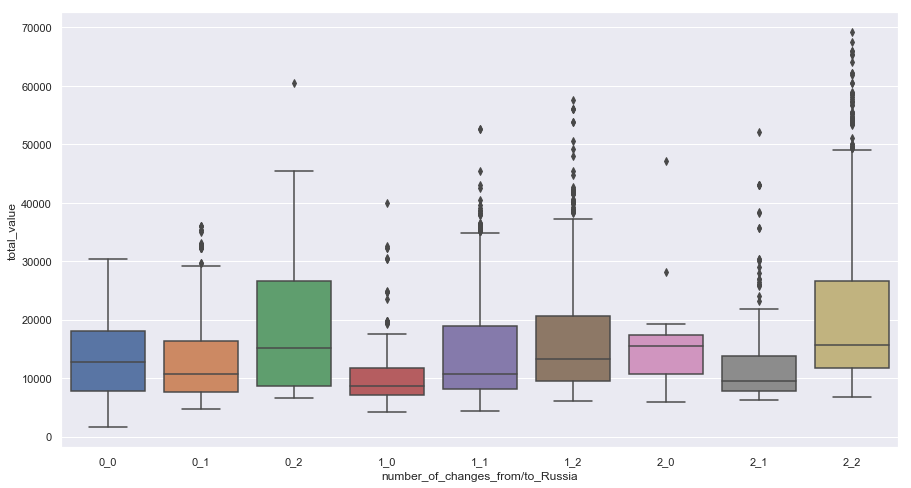

In [43]:
# посмотрим на распределение цен в зависимости от колличества пересадок

plt.figure(figsize=(15, 8))
sns.boxplot(Data_to_analys['number_of_changes_from/to_Russia'], Data_to_analys.total_value);

In [44]:
# Создадим новый признак день недели

Data_to_analys['dayofweek_depart'] = Data_to_analys.depart_date.apply(lambda x: x.dayofweek)
Data_to_analys['dayofweek_return'] = Data_to_analys.return_date.apply(lambda x: x.dayofweek)

Data_to_analys['dayofweek_depart'] = Data_to_analys.depart_date.apply(lambda x: x.dayofweek).map({0:'Monday',
                                                                                                  1:'Tuesday',
                                                                                                  2:'Wednesday',
                                                                                                  3:'Thursday',
                                                                                                  4:'Friday',
                                                                                                  5:'Saturday',
                                                                                                  6:'Sunday'})

Data_to_analys['dayofweek_return'] = Data_to_analys.return_date.apply(lambda x: x.dayofweek).map({0:'Monday',
                                                                                                  1:'Tuesday',
                                                                                                  2:'Wednesday',
                                                                                                  3:'Thursday',
                                                                                                  4:'Friday',
                                                                                                  5:'Saturday',
                                                                                                  6:'Sunday'})

Data_to_analys['dayofweek_depart_return'] = Data_to_analys['dayofweek_depart'] + '_' + Data_to_analys['dayofweek_return']

In [45]:
# Создадим новый признак колличество дней от покупки билета до вылета

Data_to_analys['days_before_departure_from_Russia'] = Data_to_analys.depart_date - Data_to_analys.found_at_from_Russia
Data_to_analys['days_before_departure_to_Russia'] = Data_to_analys.return_date - Data_to_analys.found_at_to_Russia

Data_to_analys['days_before_departure_from_Russia'] = Data_to_analys.days_before_departure_from_Russia.apply(lambda x: x.days)
Data_to_analys['days_before_departure_to_Russia'] = Data_to_analys.days_before_departure_to_Russia.apply(lambda x: x.days)

### Построим модель с новыми признаками

In [46]:
#Data_to_analys.to_csv('./data/Data_to_analys_final', index=False)

In [47]:
Model_data = pd.read_csv('./data/Data_to_analys_final')

In [48]:
Model_data.columns

Index(['origin', 'destination', 'number_of_changes_from_Russia', 'number_of_changes_to_Russia', 'depart_date', 'return_date', 'found_at_from_Russia', 'found_at_to_Russia', 'duration', 'distance', 'total_value', 'number_of_changes_from/to_Russia', 'dayofweek_depart', 'dayofweek_return', 'dayofweek_depart_return', 'days_before_departure_from_Russia', 'days_before_departure_to_Russia'], dtype='object')

In [49]:
Model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979 entries, 0 to 2978
Data columns (total 17 columns):
origin                               2979 non-null object
destination                          2979 non-null object
number_of_changes_from_Russia        2979 non-null int64
number_of_changes_to_Russia          2979 non-null int64
depart_date                          2979 non-null object
return_date                          2979 non-null object
found_at_from_Russia                 2979 non-null object
found_at_to_Russia                   2979 non-null object
duration                             2979 non-null int64
distance                             2979 non-null int64
total_value                          2979 non-null int64
number_of_changes_from/to_Russia     2979 non-null object
dayofweek_depart                     2979 non-null object
dayofweek_return                     2979 non-null object
dayofweek_depart_return              2979 non-null object
days_before_departure_from_R

In [50]:
Model_data = Model_data[['origin', 'destination', 'number_of_changes_from/to_Russia', 'dayofweek_depart_return',
                         'duration', 'distance', 'total_value', 'days_before_departure_from_Russia', 
                         'days_before_departure_to_Russia']]

In [51]:
Model_data_Y = Model_data['total_value']
Model_data_X = Model_data.drop(['total_value'], axis=1)

Model_data_X = pd.get_dummies(Model_data_X, columns=['origin', 'destination', 'number_of_changes_from/to_Russia',
                                                     'dayofweek_depart_return'])

In [52]:
Model_data_X.shape

(2979, 233)

In [53]:
skf = StratifiedKFold(5, shuffle=True, random_state=55)

scores_RMSE = []
scores_R2 = []

for train_index, test_index in skf.split(Model_data_X, Model_data_Y):
   
    X_train, X_test = Model_data_X.iloc[train_index], Model_data_X.iloc[test_index]
    Y_train, Y_test = Model_data_Y.iloc[train_index], Model_data_Y.iloc[test_index]
    
    model = xgb.XGBRegressor(objective ='reg:squarederror',
                             learning_rate=0.1,
                             n_estimators=300,
                             max_depth=3,
                             min_child_weight=1,
                             gamma=0.1, 
                             colsample_bytree=0.9,
                             subsample=0.9,   
                             n_jobs=-1)
    
    
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)

    scores_R2.append(r2(Y_test, preds))
    scores_RMSE.append(np.sqrt(mse(Y_test, preds)))
    
    
print(f'RMSE is {round(np.mean(scores_RMSE), 4)}')   
print(f'R2 is {round(np.mean(scores_R2), 4)}')

RMSE is 2089.5094
R2 is 0.9486


In [54]:
# baseline:
# RMSE is 3100.2897
# R2 is 0.9245

In [55]:
# подбор гиперпараметров

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

#функция, которую будем МИНИМИЗИРОВАТЬ
def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    print("Training with params : ", params)
    clf = xgb.XGBRegressor(**params)
    clf.fit(X_train, Y_train)
    y_pred_xgb_test = clf.predict(X_test)
    RMSE = (np.sqrt(mse(Y_test, y_pred_xgb_test)))
   
    print('TEST RMSE: {}'.format(RMSE))
    return RMSE



space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.1),
         'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.1),
         'silent' : 1,
         'n_estimators': hp.choice('n_estimators', [100, 500]),
         'learning_rate': hp.choice('learning_rate', [0.1,0.01])
         }

trials = Trials()

best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=50, show_progressbar=False)

Training with params :  {'colsample_bytree': 0.7000000000000001, 'gamma': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 9.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.6000000000000001, 'n_jobs': -1}
TEST RMSE: 6978.77756457357
Training with params :  {'colsample_bytree': 1.0, 'gamma': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 7.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.6000000000000001, 'n_jobs': -1}
TEST RMSE: 1228.762972995679
Training with params :  {'colsample_bytree': 0.8, 'gamma': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.9, 'n_jobs': -1}
TEST RMSE: 7532.956974264211
Training with params :  {'colsample_bytree': 0.9, 'gamma': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.7000000000000001, 'n_jobs': -1}
TEST RMSE: 2300.222798396603
Training with params :  {'colsample_bytree': 0.60

In [56]:
best

{'colsample_bytree': 1.0,
 'gamma': 0.65,
 'learning_rate': 0,
 'max_depth': 8.0,
 'min_child_weight': 6.0,
 'n_estimators': 1,
 'subsample': 0.9}

In [57]:
skf = StratifiedKFold(5, shuffle=True, random_state=55)

scores_RMSE = []
scores_R2 = []

for train_index, test_index in skf.split(Model_data_X, Model_data_Y):
   
    X_train, X_test = Model_data_X.iloc[train_index], Model_data_X.iloc[test_index]
    Y_train, Y_test = Model_data_Y.iloc[train_index], Model_data_Y.iloc[test_index]
    
    model = xgb.XGBRegressor(objective ='reg:squarederror',
                             colsample_bytree=0.8,
                             gamma=0.9,
                             subsample=0.7,
                             n_estimators=500,
                             learning_rate=0.1,
                             max_depth=10,
                             min_child_weight=9,
                             n_jobs=-1)
    
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)

    scores_R2.append(r2(Y_test, preds))
    scores_RMSE.append(np.sqrt(mse(Y_test, preds)))
    
    
print(f'RMSE is {round(np.mean(scores_RMSE), 4)}')   
print(f'R2 is {round(np.mean(scores_R2), 4)}')

RMSE is 1710.1559
R2 is 0.9545


In [58]:
# Посмотрим на взаимодействия признаков

import xgbfir
xgbfir.saveXgbFI(model, OutputXlsxFile='xgbfi_report.xlsx')

In [59]:
pd.read_excel('./xgbfi_report.xlsx', sheet_name=1)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,distance|distance,1.281944e+12,339,82.006321,0.241907,3.781547e+09,7.642626e+11,1,1,1,40,10,1,9.000000,43.510324,5.581121
1,distance|number_of_changes_from/to_Russia_2_2,3.653228e+11,34,2.969078,0.087326,1.074479e+10,3.287629e+10,2,15,31,73,2,2,20.833333,34.558824,4.323529
2,destination_BCN|distance,5.754338e+10,8,1.942439,0.242805,7.192922e+09,1.552892e+10,3,48,41,39,6,6,23.833333,16.375000,2.625000
3,distance|duration,3.797980e+10,293,27.894271,0.095202,1.296239e+08,3.618668e+09,4,2,2,68,84,18,29.666667,52.549488,6.184300
4,distance|origin_MOW,3.377018e+10,73,9.112701,0.124832,4.626052e+08,5.837933e+09,5,9,10,60,59,15,26.333333,37.082192,6.150685
5,destination_BCN|destination_LIS,2.748797e+10,6,1.438406,0.239734,4.581328e+09,6.611740e+09,6,53,56,42,7,14,29.666667,3.666667,3.000000
6,duration|duration,2.600755e+10,252,22.441035,0.089052,1.032046e+08,3.001514e+09,7,3,3,71,89,20,32.166667,50.551587,6.444444
7,destination_TAS|distance,2.260255e+10,17,10.428149,0.613421,1.329562e+09,1.339759e+10,8,27,7,17,27,9,15.833333,26.882353,4.000000
8,destination_SIP|duration,2.238347e+10,34,3.687587,0.108458,6.583375e+08,1.106968e+10,9,16,26,65,48,11,29.166667,37.147059,6.470588
9,destination_DYU|distance,2.018275e+10,16,12.026892,0.751681,1.261422e+09,1.179631e+10,10,29,6,9,30,10,15.666667,27.625000,1.937500


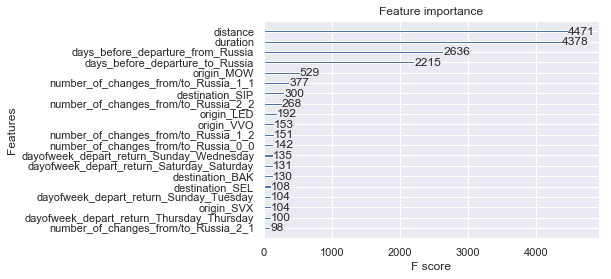

In [60]:
xgb.plot_importance(model, max_num_features = 20)
plt.show()

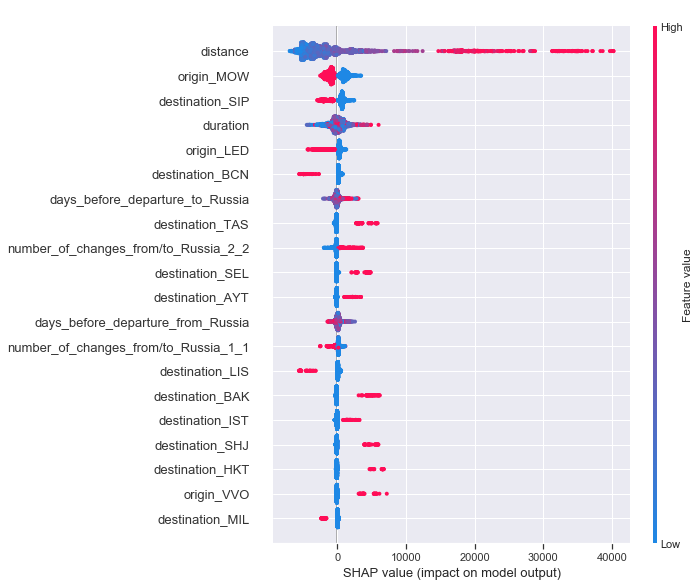

In [61]:
import shap

model = xgb.XGBRegressor(objective ='reg:squarederror',
                         colsample_bytree=0.8,
                         gamma=0.9,
                         subsample=0.7,
                         n_estimators=500,
                         learning_rate=0.1,
                         max_depth=10,
                         min_child_weight=9,
                             n_jobs=-1)
model.fit(Model_data_X, Model_data_Y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Model_data_X)

shap.summary_plot(shap_values, Model_data_X)

In [62]:
# Посмотрим на качество catboost

In [63]:
categorical_features = Model_data_X.dtypes[Model_data_X.dtypes=='object'].index

cat_features = categorical_features
skf = StratifiedKFold(5, shuffle=True, random_state=55)

scores_RMSE = []
scores_R2 = []

for train_index, test_index in skf.split(Model_data_X, Model_data_Y):
   
    
    X_train, X_test= Model_data_X.iloc[train_index], Model_data_X.iloc[test_index]
    y_train, y_test= Model_data_Y.iloc[train_index], Model_data_Y.iloc[test_index]
    
    model = catboost.CatBoostRegressor(depth=7, learning_rate=0.1, iterations=300)

    model.fit(X_train, y_train, cat_features=cat_features, logging_level='Silent')
    
    
    preds = model.predict(X_test)
    scores_R2.append(r2(y_test, preds))
    scores_RMSE.append(np.sqrt(mse(y_test, preds)))
    
print(f'RMSE is {round(np.mean(scores_RMSE), 4)}')   
print(f'R2 is {round(np.mean(scores_R2), 4)}')

RMSE is 1986.5513
R2 is 0.9517


Выводы:
В основном цены зависят от дальности и длительности полета,также от города вылета(из Москвы дешевле), 
колличества пересадок, дня недели. 
baseline для xgboost: RMSE is 3100.2897, R2 is 0.9245 после добавления новых фичей качество повысилось: 
RMSE is 2089.5094, R2 is 0.9486, а после подбора гиперпараметров: RMSE is 1710.1559, R2 is 0.9545.
Catboost немного уступил, но его нужно было попробывать, так как он лучше работает с категориальными фичами, а их 
больше 50%. Доля обьясняемой дисперсии очень высокая. Чтобы улучшить результаты, нужно найти данные о том,
какая компания выполняет авиарейс(лоукостер, чартер) какой аэропорт вылета, в каком конкретно происходит пересадка,
в какое время суток отправление. Также поможет увеличение колличества данных для обучения(из-за пандемии рейсов в 
данный момент мало)